##1. Download the Dataset

In [1]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 238MB/s]


In [2]:
!unzip -qq ECG5000.zip

##2. Setup Device agnostic code.

In [3]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##3. Import the required dependencies.

In [4]:
import torch
import scipy
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p
from scipy.io import arff

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [5]:
with open('ECG5000_TRAIN.arff') as f:
  train = arff.loadarff(f)
with open('ECG5000_TEST.arff') as f:
  test = arff.loadarff(f)

In [6]:
test_df = pd.DataFrame(test[0])
train_df = pd.DataFrame(train[0])
df = pd.concat([train_df, test_df],ignore_index=True)
df['target'] = df['target'].apply(lambda x: str(x.decode('utf-8')))
df = df.sample(frac=1.0)
df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1501,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2586,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2653,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
1055,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
705,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,-0.248881,-1.346474,-1.855199,-2.519039,-2.947360,-3.233288,-3.087431,-2.668242,-1.970671,-1.390033,...,-1.157266,-1.605818,-2.286109,-3.247334,-3.551343,-3.426098,-2.171479,-1.380595,-0.378163,2
466,-0.287286,-1.199089,-1.563916,-2.078314,-2.456073,-2.508211,-2.465002,-2.445333,-2.320656,-1.995150,...,-2.061417,-2.679767,-3.228270,-3.584828,-3.629377,-3.000843,-2.079477,-1.307187,0.075742,2
3092,-1.032096,-2.811901,-3.588706,-3.883206,-3.279964,-2.275187,-1.771033,-1.603019,-0.956392,-0.764538,...,1.280471,1.353143,1.526594,1.429218,1.099634,1.245052,1.568047,1.776520,0.750669,1
3772,-1.592541,-2.461370,-2.524132,-3.062815,-2.968224,-2.784655,-2.738399,-2.431311,-2.063169,-1.555809,...,-2.179744,-2.624303,-3.107874,-3.102964,-2.746384,-1.972664,-1.077676,-0.707541,0.354016,2


##4. What are we looking for??

* Normal.
* R on T Premature Ventricular Contraction (R-on-T PVC)
* Premature ventricular Contraction (PVC)
* Supra-ventricular Premature or ectopic Beat (SP or EB)
* Unclassified Beat(UB)

In [7]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']



##5. Data Preprocessing

In [8]:
# new_columns = list(df.columns)
# new_columns = 'target'
# df.columns = new_columns

##6. Data Exploration

In [9]:
df.target.value_counts()

,count
target,
1,2919
2,1767
4,194
3,96
5,24


<ipython-input-10-79c2e313e696>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target',data=df,palette='husl')
<ipython-input-10-79c2e313e696>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names);


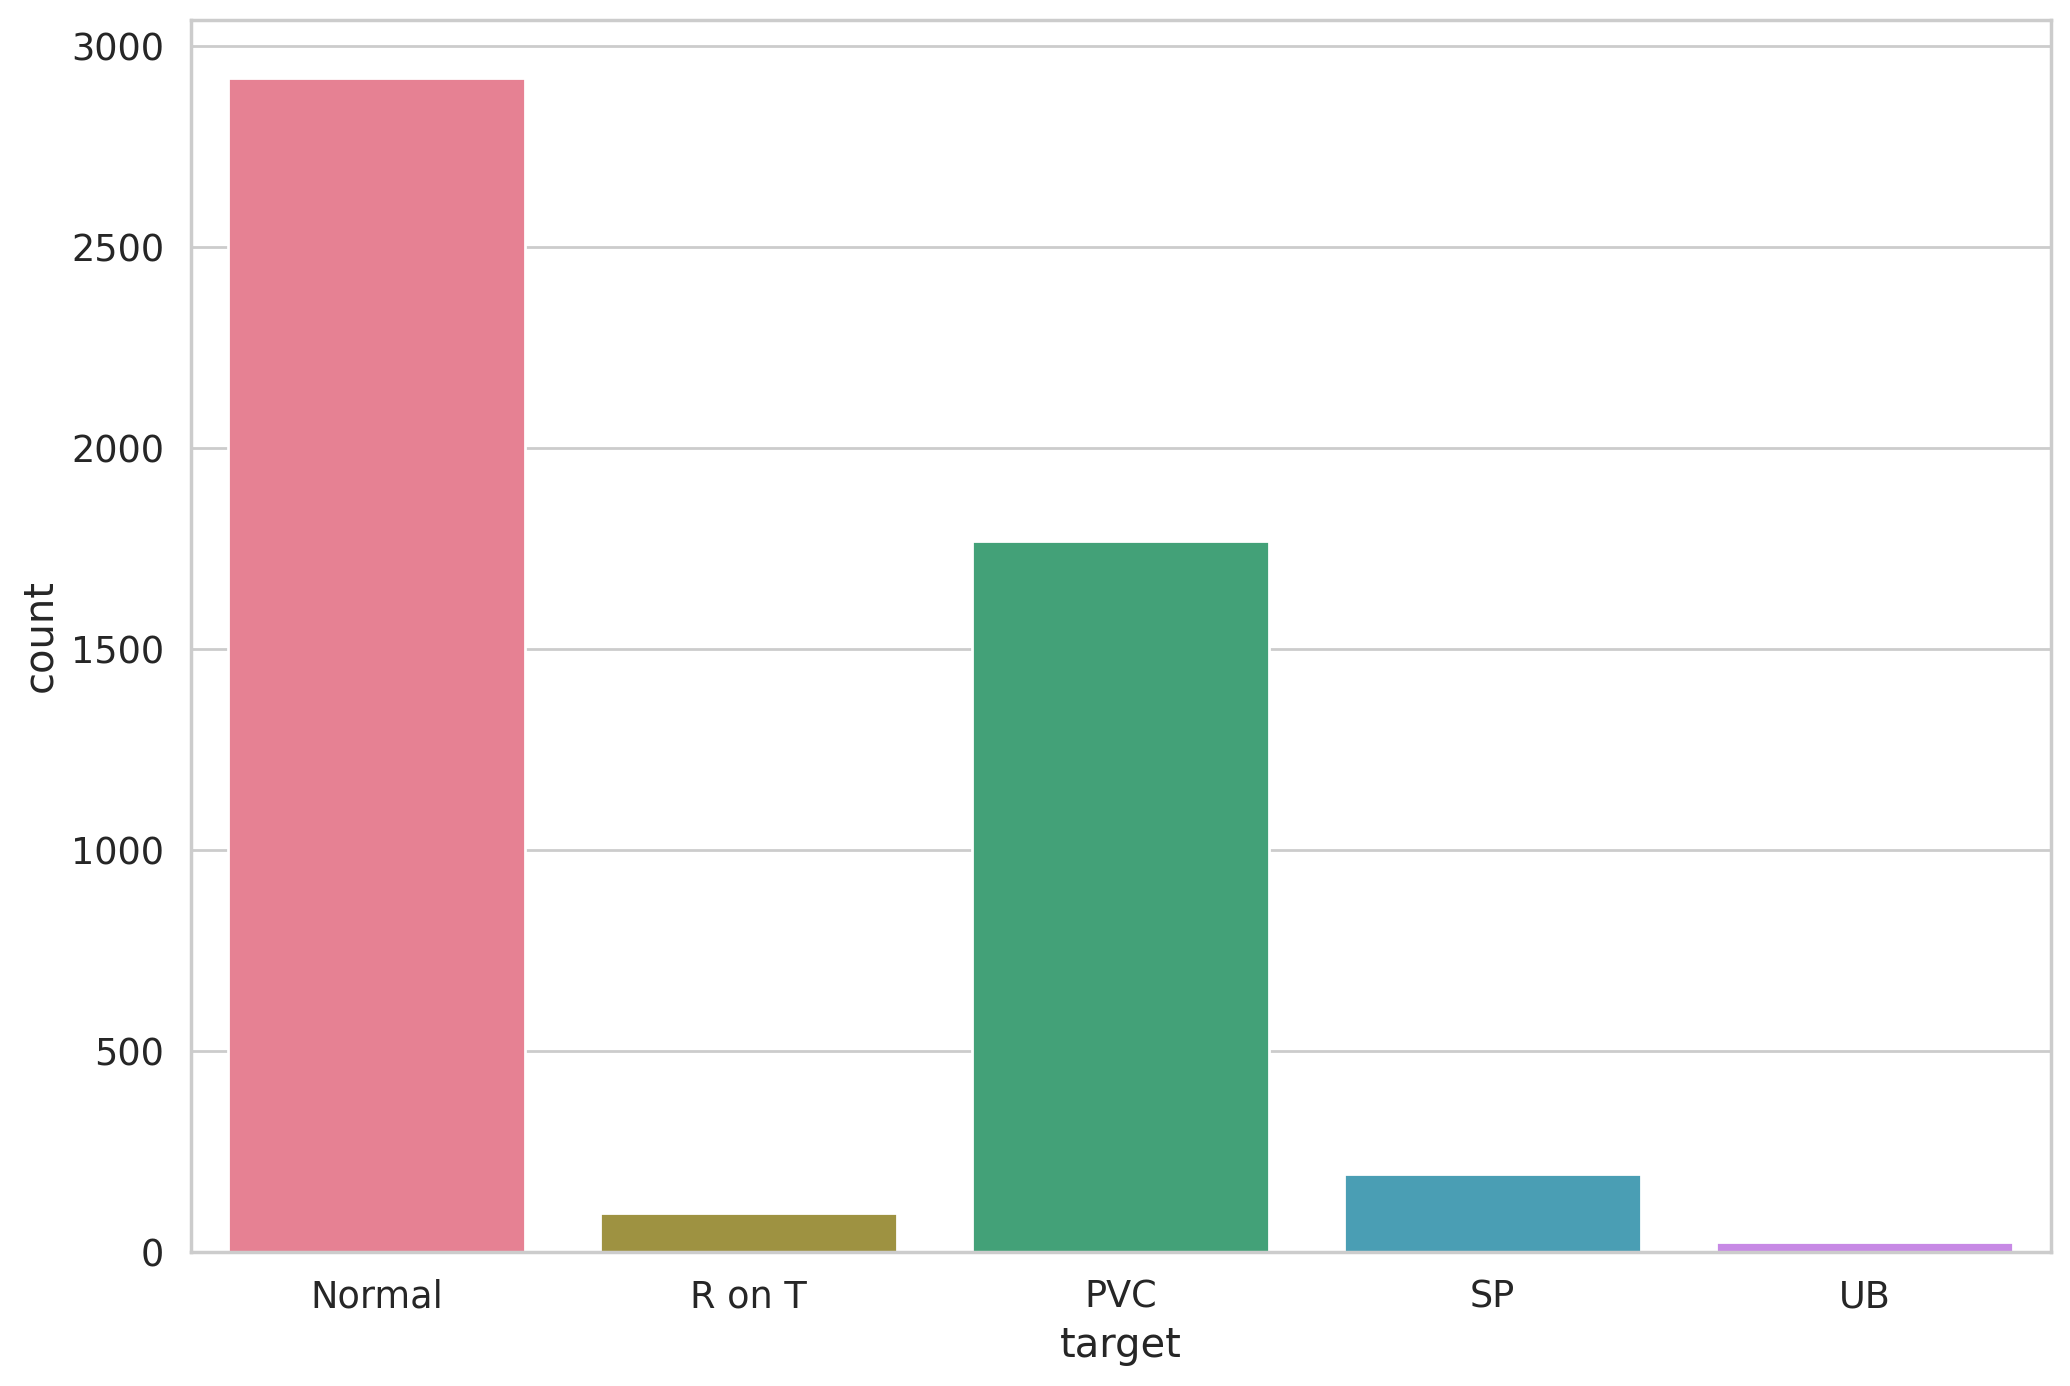

In [10]:
ax = sns.countplot(x='target',data=df,palette='husl')
ax.set_xticklabels(class_names);

In [11]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)


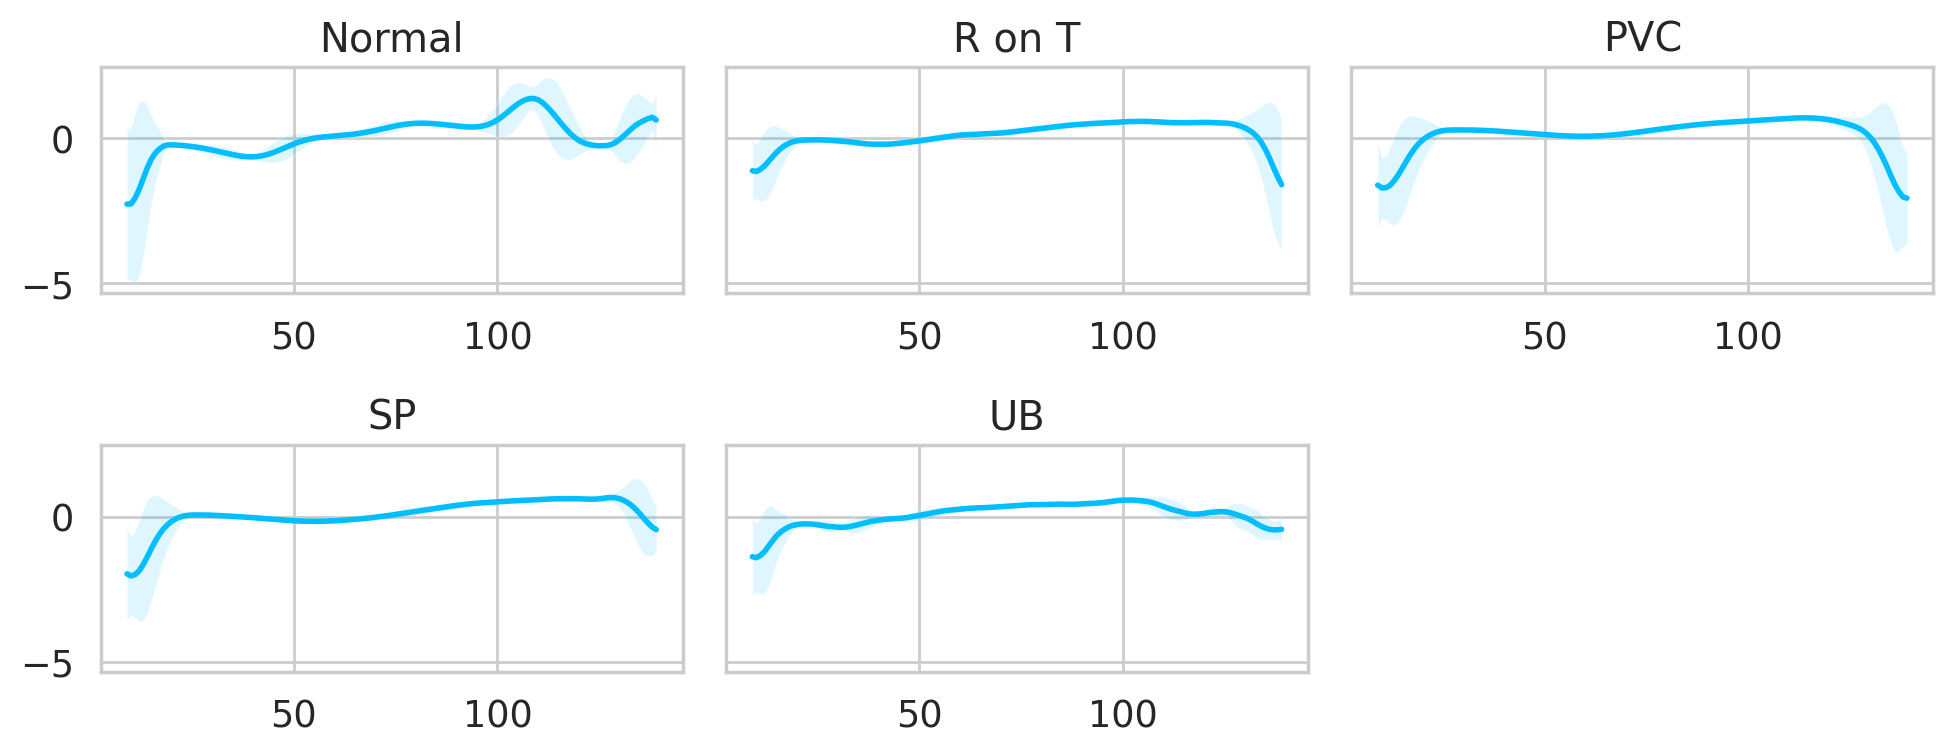

In [12]:
classes = df.target.unique()

fig, axis = plt.subplots(
    nrows = len(classes) // 3+1,
    ncols = 3,
    sharey=True,
    figsize=(10,4)
)

for i, cls in enumerate(classes):
  ax = axis.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target',axis=1)\
    .mean(axis=0)\
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axis.flat[-1])
fig.tight_layout();

##7. More Data Preprocessing.

In [13]:

normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [14]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape


(2081, 140)

In [15]:
train_df, val_df = \
  train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = \
  train_test_split(
  val_df,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [16]:
train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

In [17]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [18]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

###8. Building an LSTM Autoencoder.

In [19]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [20]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [21]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [22]:
model = RecurrentAutoencoder(seq_len,n_features,embedding_dim=128)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

##9. Let's train our model...

In [23]:
def train_model(model, train_dataset,val_dataset, epochs):
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)

  history = dict(train=[],val=[])

  for epoch in range(1,epochs + 1):
    model = model.train()

    train_loss = []

    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred,seq_true)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())


    val_loss = []
    model = model.eval()

    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred,seq_true)

        val_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    val_loss = np.mean(val_loss)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  # model.load_state_dict(best_model_wts)
  return model.eval(), history

In [24]:
model, history = train_model(model,train_dataset,val_dataset, epochs=30)

Epoch 1: train loss 66.04732513812125 val loss 53.416068961086886
Epoch 2: train loss 52.779205385305765 val loss 60.30938727670608
Epoch 3: train loss 49.967706261311555 val loss 46.30222839634168
Epoch 4: train loss 39.10792704447293 val loss 37.483923559319486
Epoch 5: train loss 35.02392430557257 val loss 32.582817996473615
Epoch 6: train loss 32.028894622784286 val loss 31.149691250770605
Epoch 7: train loss 28.35933726547899 val loss 27.34841482171185
Epoch 8: train loss 26.678416552345677 val loss 24.96614168332592
Epoch 9: train loss 26.051449151829047 val loss 25.870393679022246
Epoch 10: train loss 25.21627584977863 val loss 22.942635340233373
Epoch 11: train loss 24.73415016810868 val loss 25.128260525394246
Epoch 12: train loss 24.611163433786842 val loss 26.026041335711195
Epoch 13: train loss 22.74400144390212 val loss 21.384333144584204
Epoch 14: train loss 21.140040373811797 val loss 21.91204628879077
Epoch 15: train loss 20.013450647544015 val loss 21.11564814336768
Ep

##11. Let's save our model

In [26]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [27]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

<ipython-input-28-1903679c7b05>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


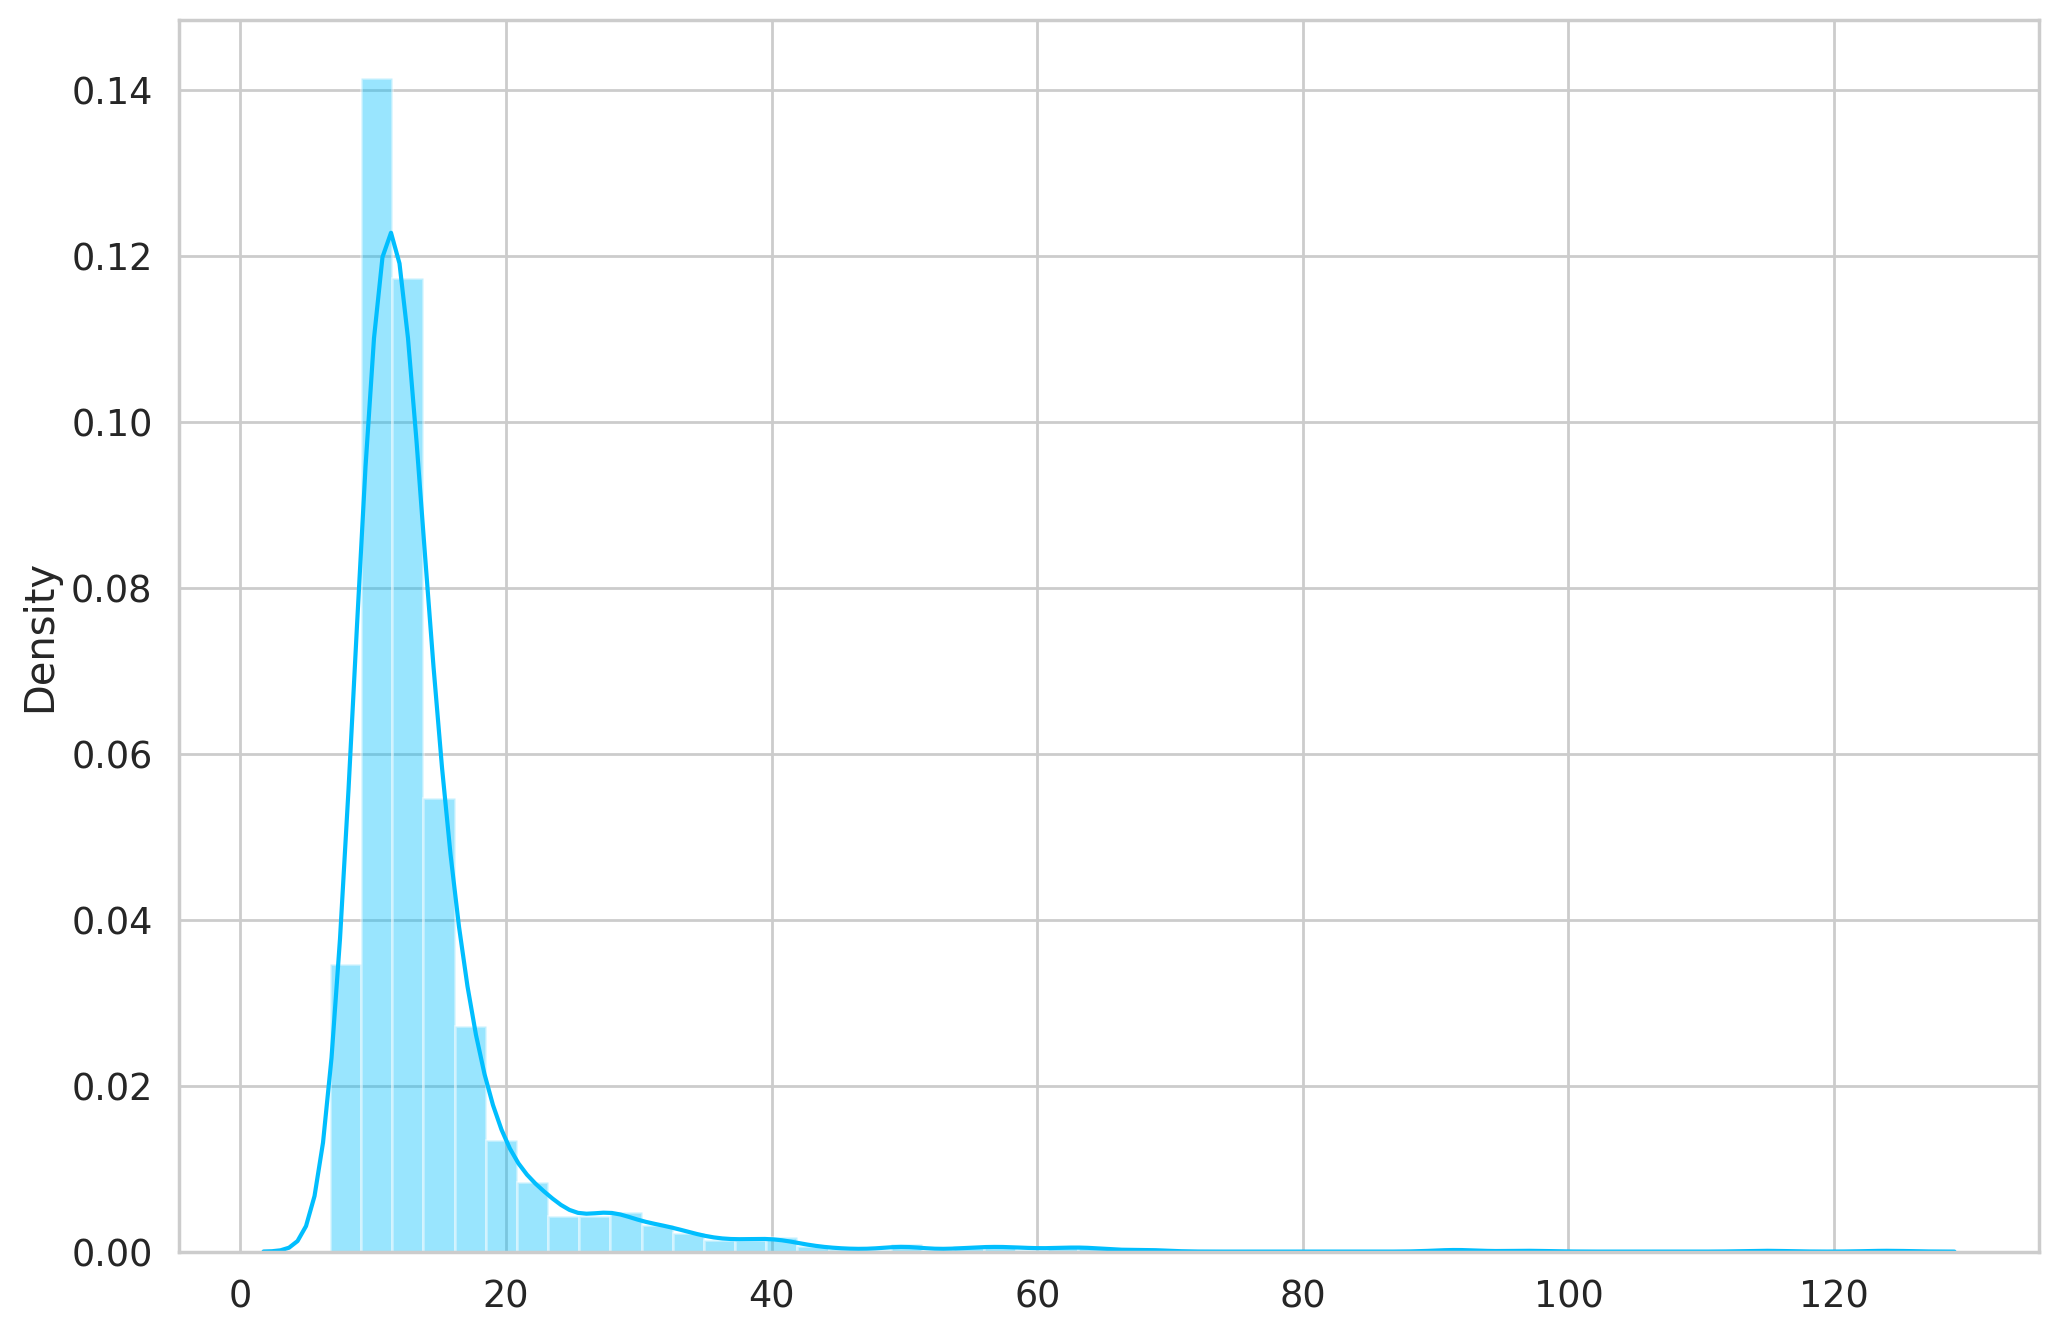

In [28]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);


In [29]:
THRESHOLD = 26

<ipython-input-30-ed53989f8e41>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


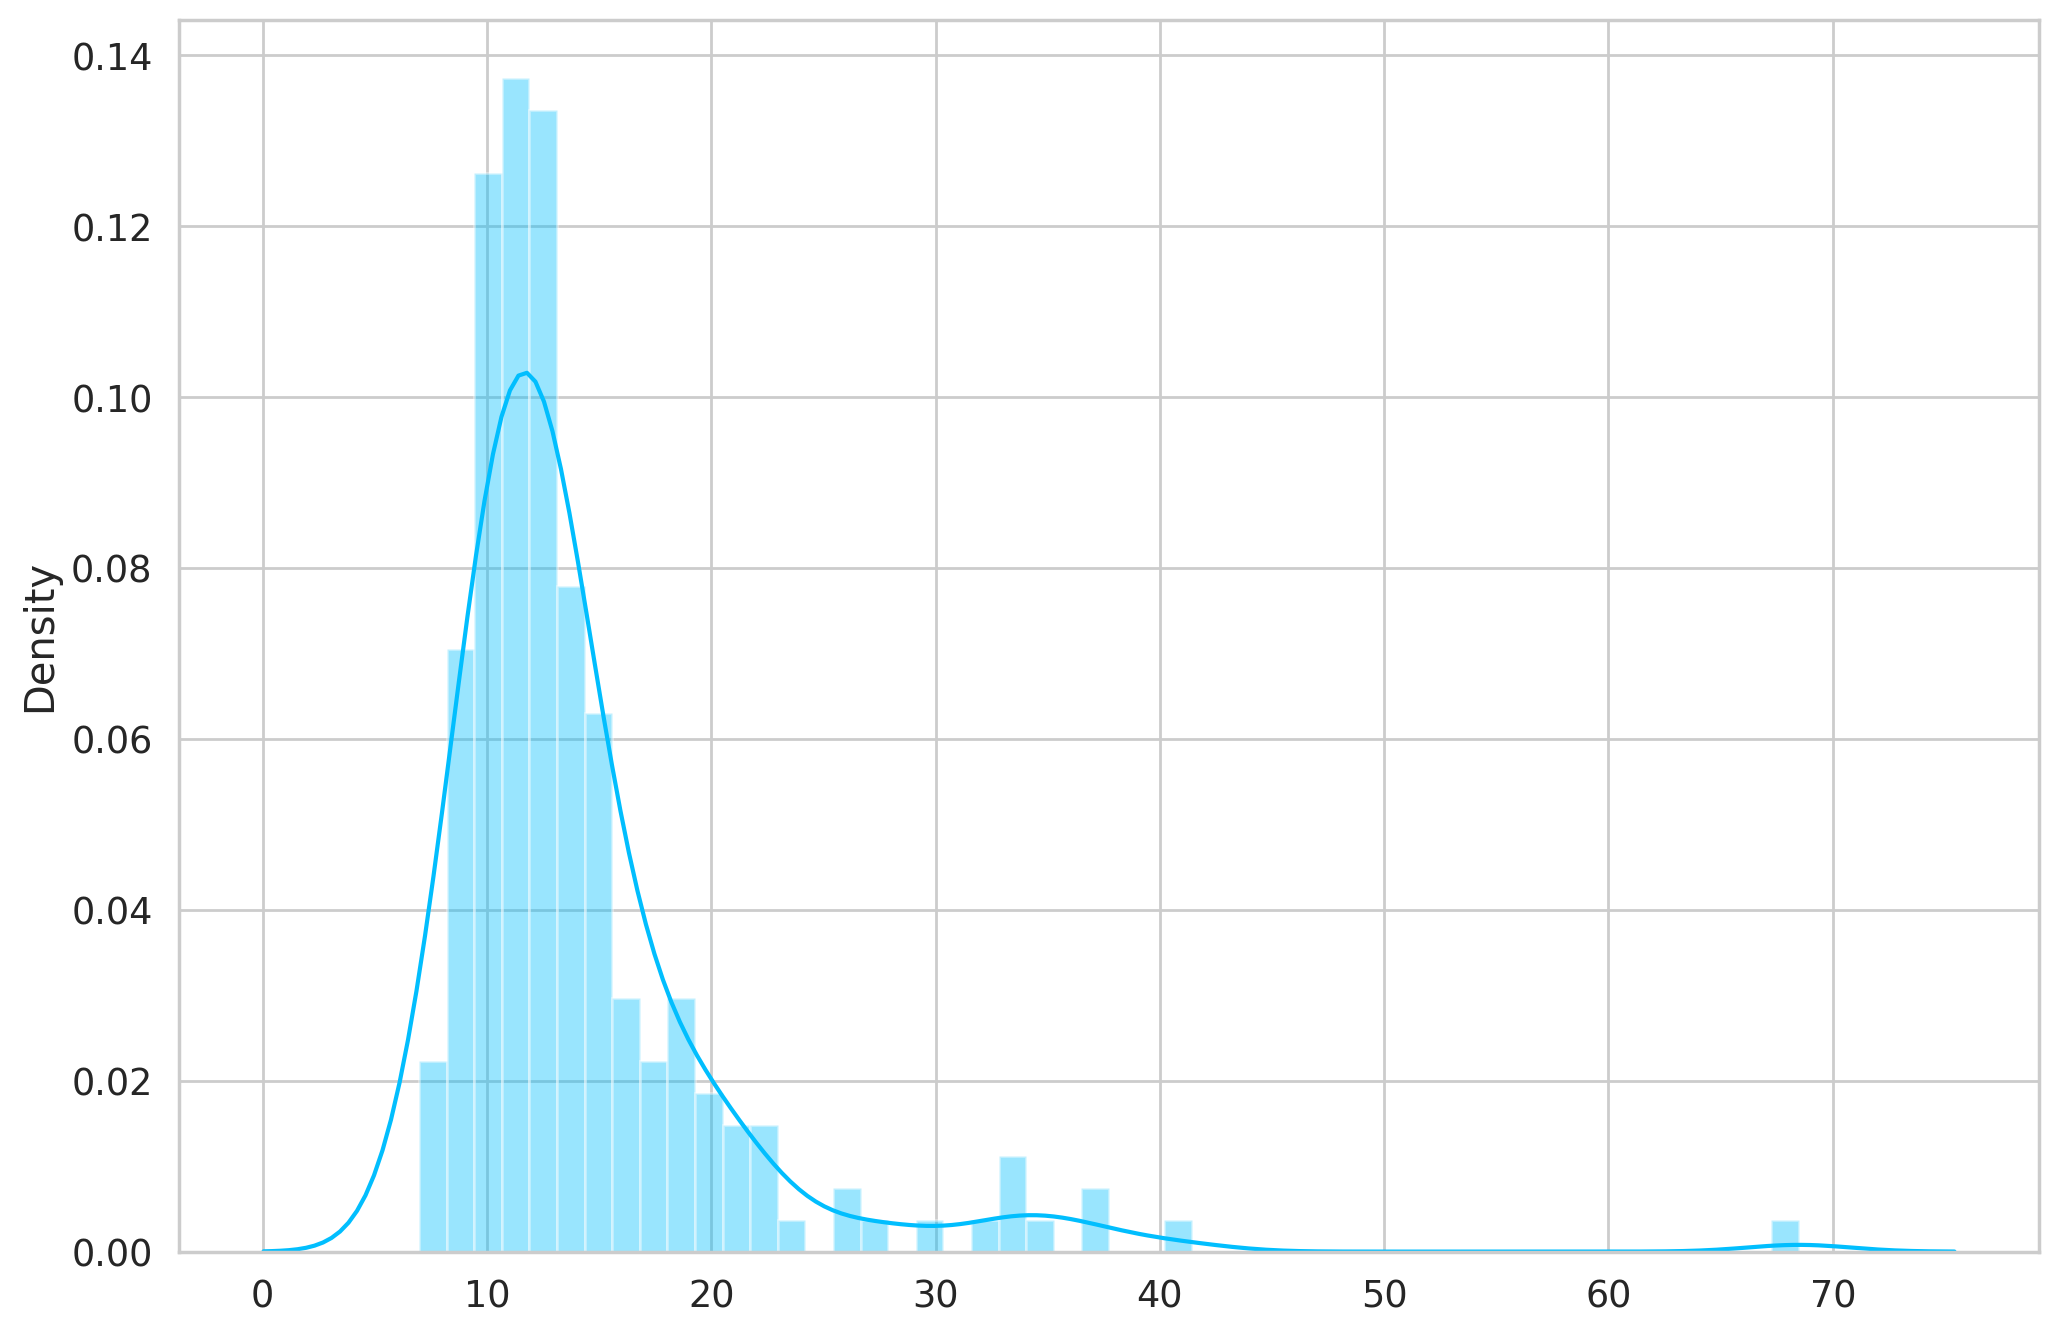

In [30]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [31]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 206/219


##12. Let's now handle the reconstruction error. We will use a pre trained model by Vanalik

###12.1. Let's download and load our model.





In [32]:
!gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
model = torch.load('model.pth')
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
To: /content/model.pth
100% 3.98M/3.98M [00:00<00:00, 198MB/s]


<ipython-input-32-0bcce81f5013>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pth')
/usr/local/lib/python3.10/dist-packages/torch/serialization.

###12.2. Choose a threshold.

In [33]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses


<ipython-input-34-1903679c7b05>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


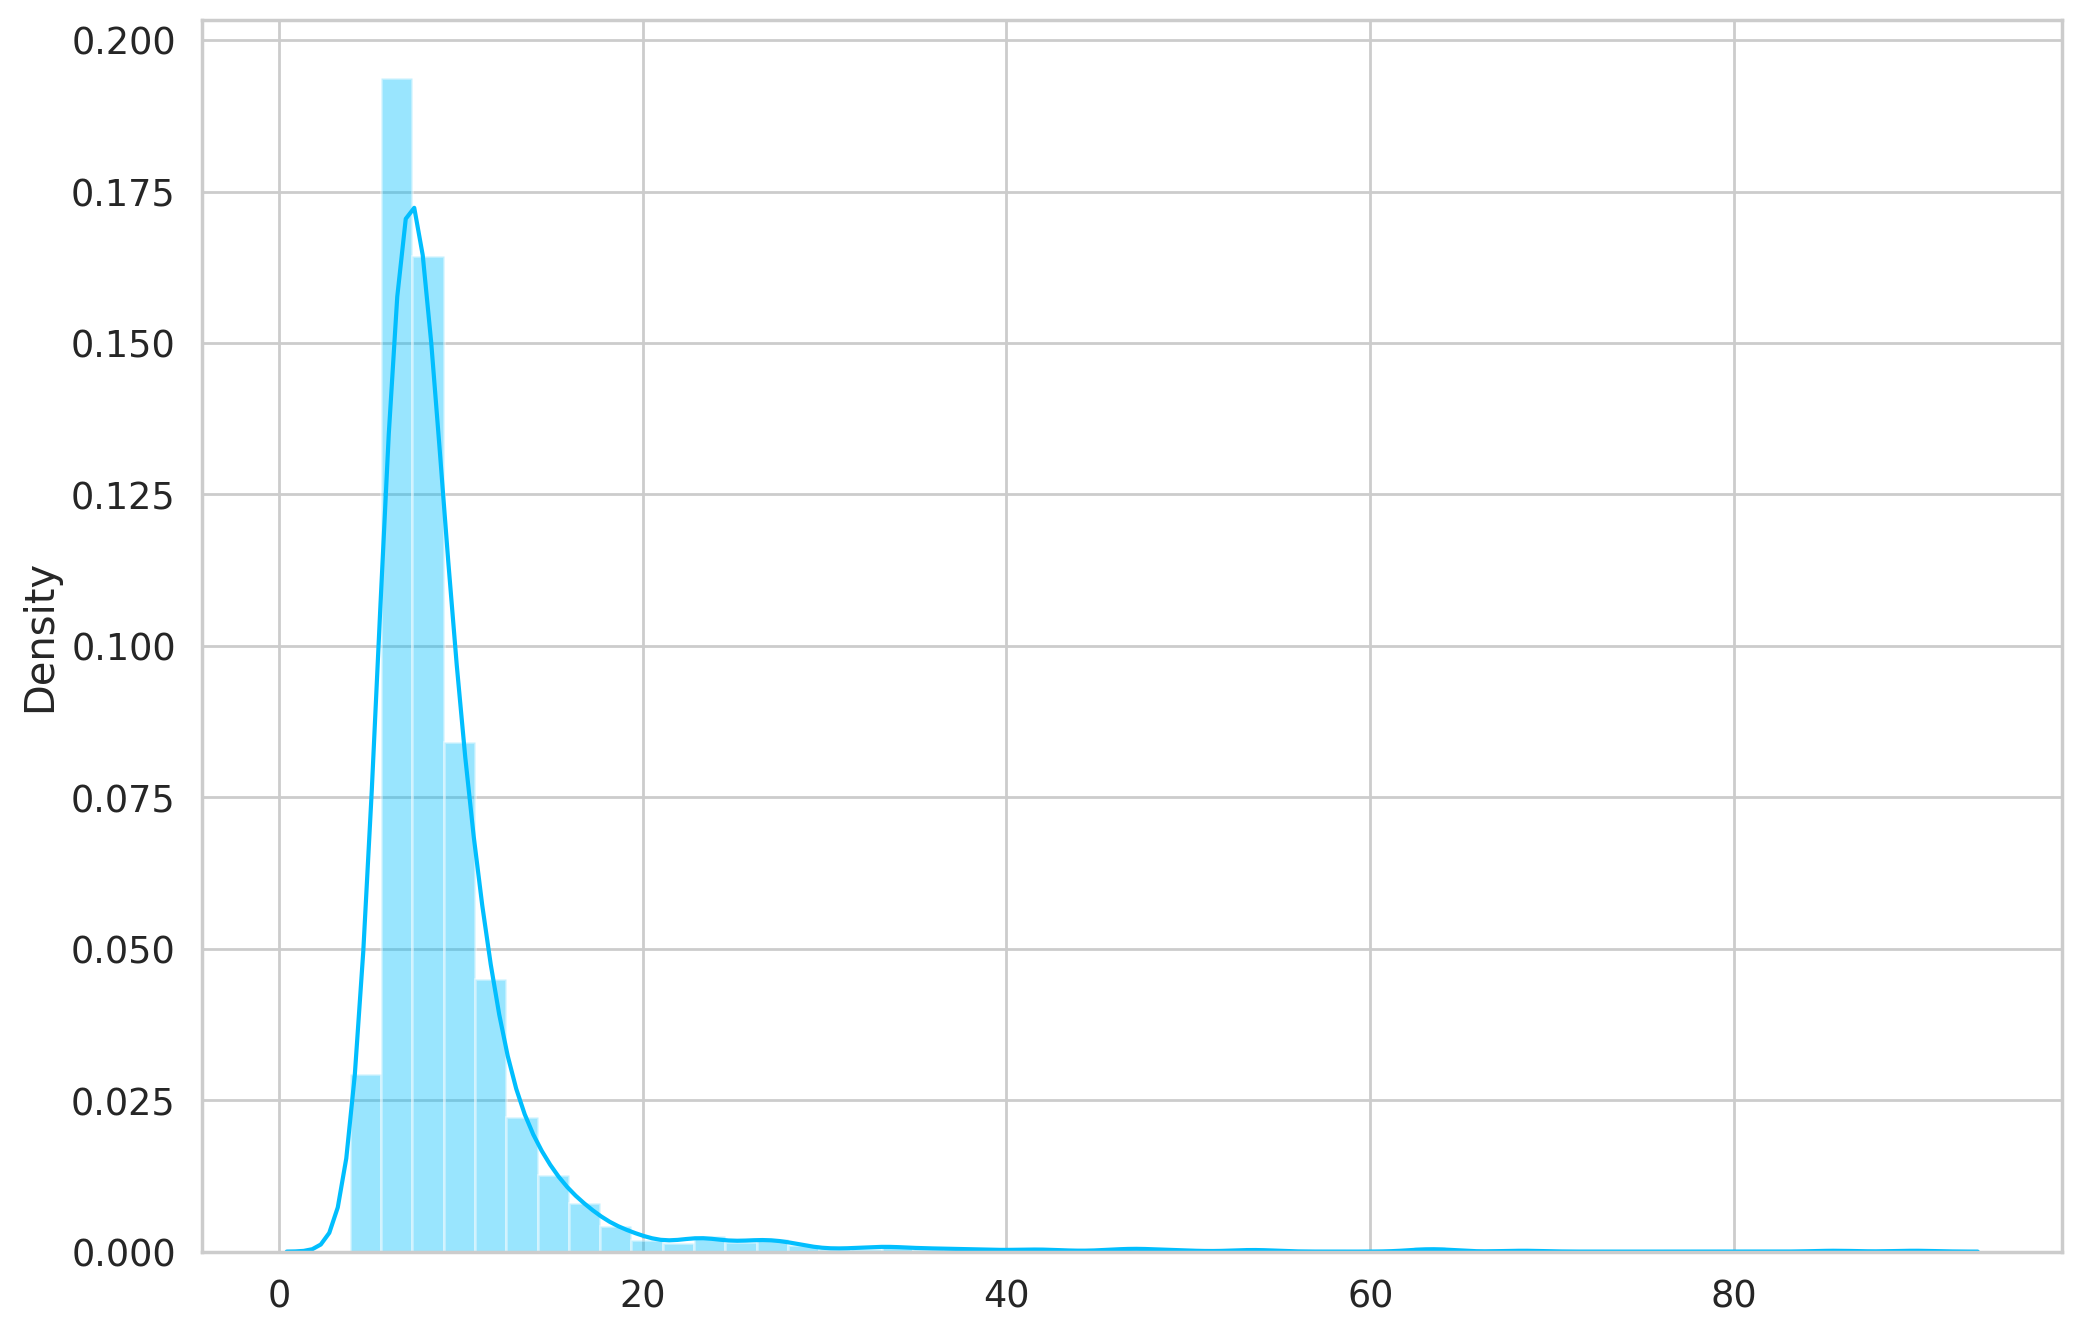

In [34]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);


In [35]:
THRESHOLD = 26

###12.3. Evaluation.

<ipython-input-36-6df872aa0542>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


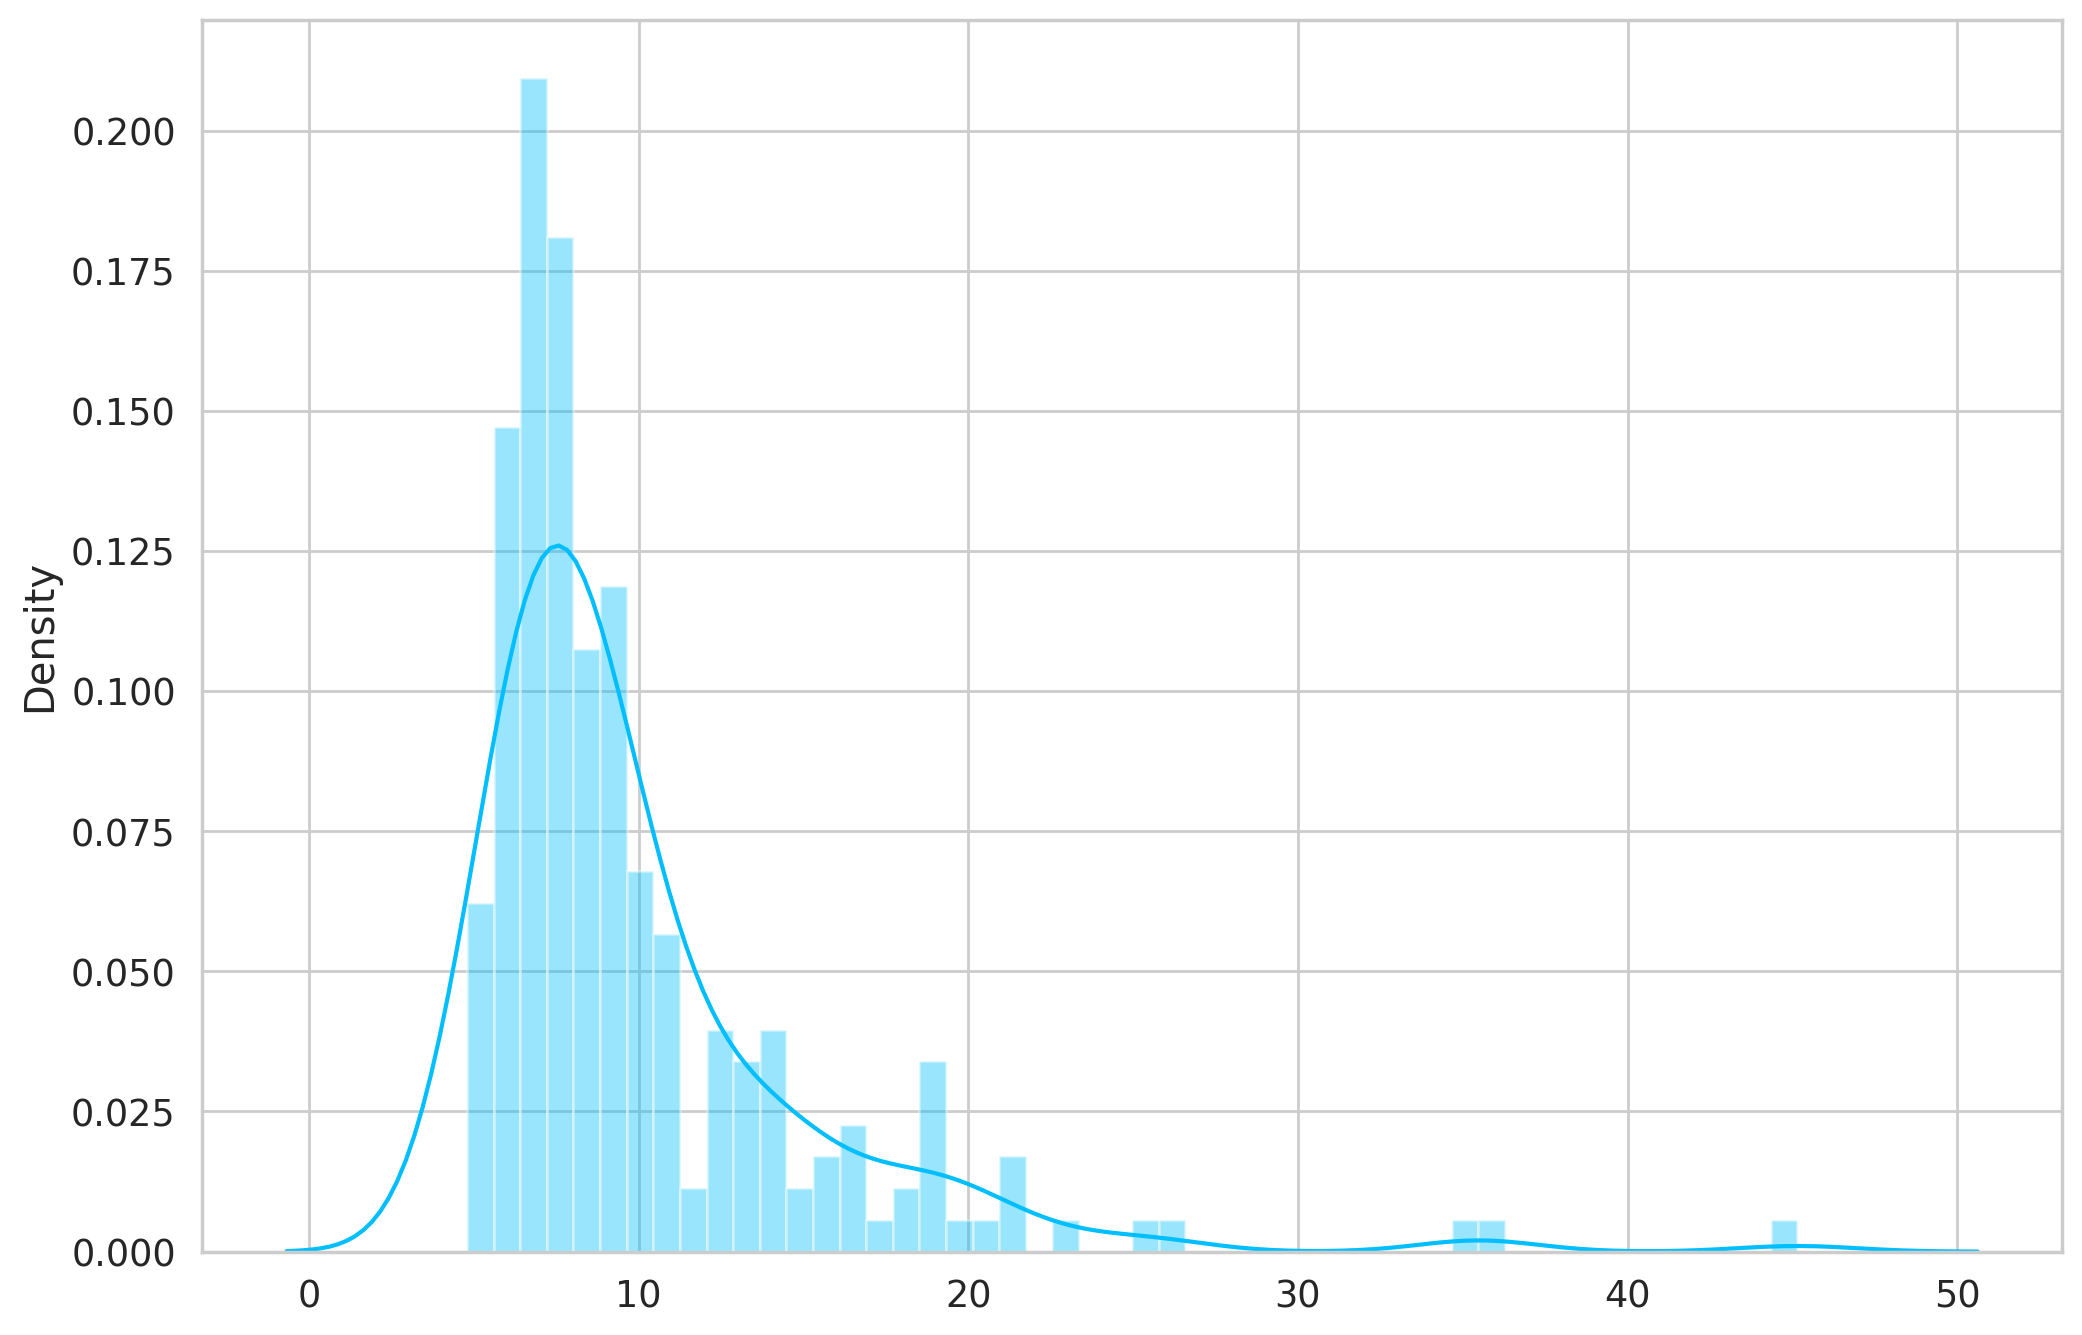

In [36]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);


In [37]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 216/219


###12.2. Using our model now lets look at the anomalies

In [38]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

<ipython-input-39-ad94685d44b0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


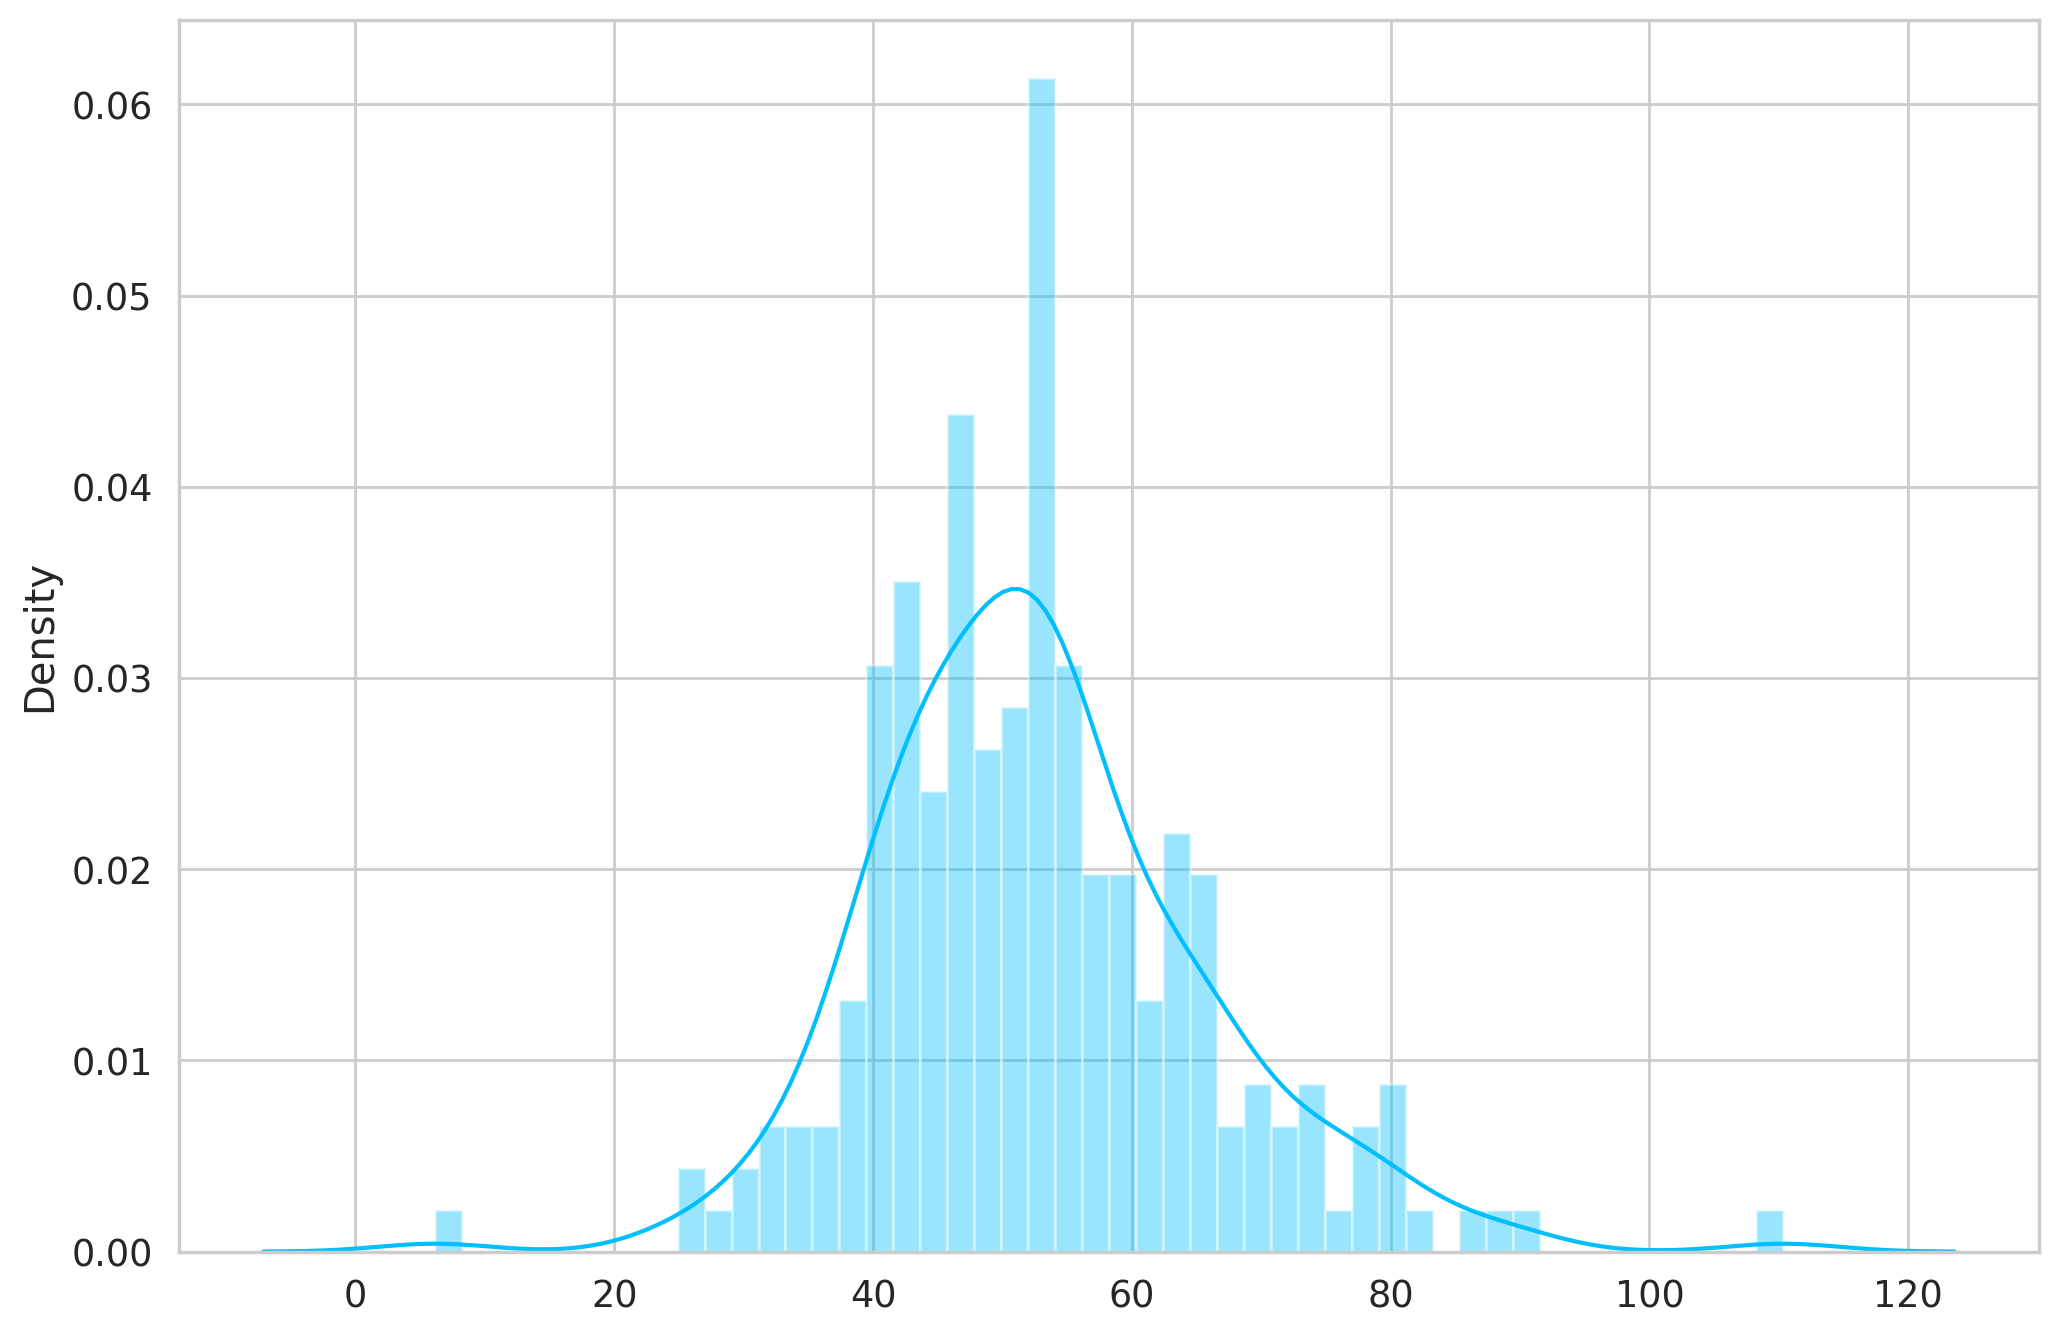

In [39]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [46]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 216/219


In [41]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

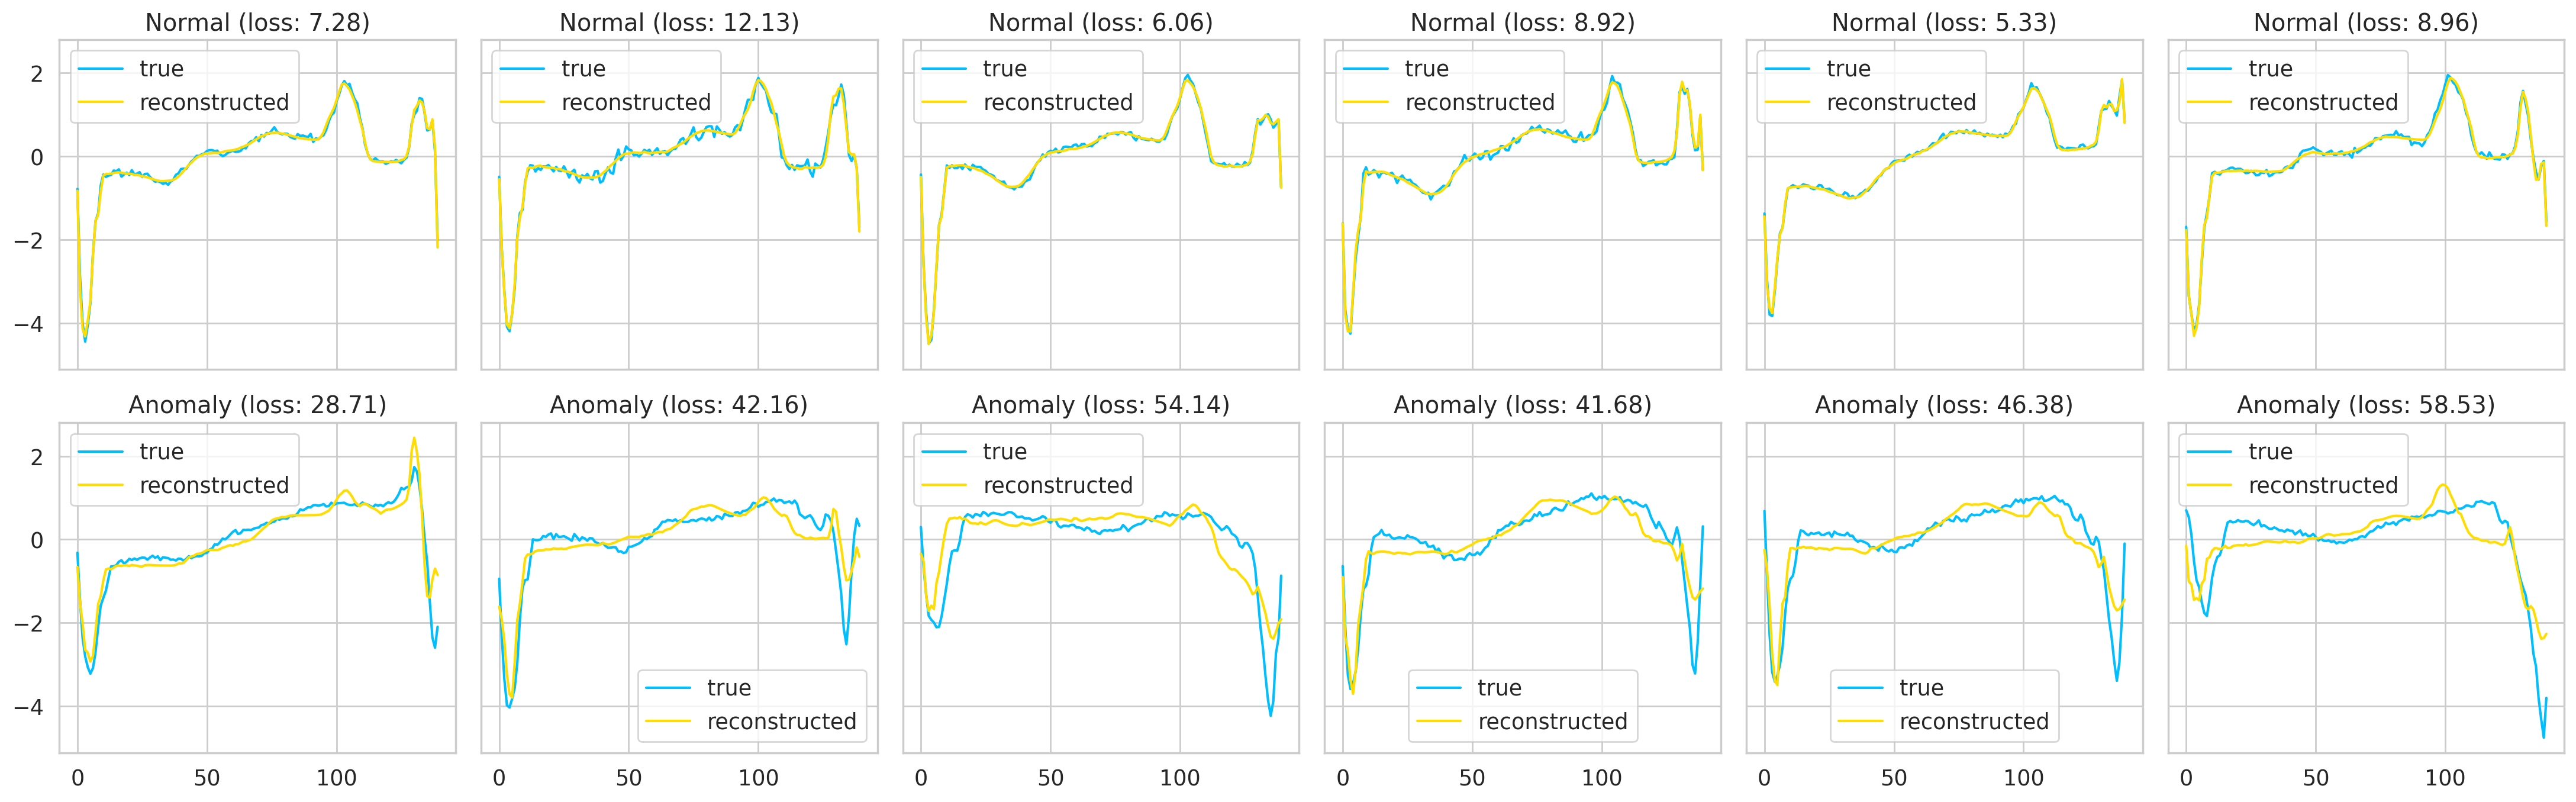

In [44]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 7)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();